In [1]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 11.4MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 11.4MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 11.9MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 11.2MB/s ta 0:00:01
    100% |████████████████████████████████| 143kB 16.6MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 13.5MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 19.9MB/s ta 0:00:01
  Stored in directory: /home/chsu/.cache/pip/wheels/ee/97/c5/87dcdc9434fe4e632ed5945e31a03703af229db178ef6a00e8
  Stored in directory: /home/chsu/.cache/pip/wheels/16/7f/c3/6b0582283ad589d68a306da924a78c74546e010d8106b9b3a9
Successfully built kaggle python-slugify


In [2]:
import os
import glob
import zipfile

import functools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [3]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

# Get all the files

In [6]:
import os

def get_kaggle_credentials():
    token_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
    token_file = os.path.join(token_dir, "kaggle.json")
    if not os.path.isdir(token_dir):
        os.mkdir(token_dir)
    try:
        with open(token_file,'r') as f:
            pass
    except IOError as no_file:
        try:
            from google.colab import files
        except ImportError:
            raise no_file

        uploaded = files.upload()

        if "kaggle.json" not in uploaded:
            raise ValueError("You need an API key! see:"
                             "https://github.com/Kaggle/kaggle-api#api-credentials")
        with open(token_file, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(token_file, 600)

get_kaggle_credentials()                

In [9]:
import kaggle

# Download data from Kaggle

In [10]:
competition_name = 'carvana-image-masking-challenge'

In [12]:
def load_data_from_zip(competition, file):
    with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
        unzipped_file = zip_ref.namelist()[0]
        zip_ref.extractall(competition)
        
def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')

In [13]:
get_data(competition_name)

In [14]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [17]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [22]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [23]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [28]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


In [29]:
x_train_filenames[:10]

['carvana-image-masking-challenge/train/69915dab0755_16.jpg',
 'carvana-image-masking-challenge/train/695f39dfac16_04.jpg',
 'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg',
 'carvana-image-masking-challenge/train/562706000bd7_15.jpg',
 'carvana-image-masking-challenge/train/917f262f1608_06.jpg',
 'carvana-image-masking-challenge/train/fce0ba5b8ed7_07.jpg',
 'carvana-image-masking-challenge/train/93881caf9f70_10.jpg',
 'carvana-image-masking-challenge/train/eb07e3f63ad2_09.jpg',
 'carvana-image-masking-challenge/train/78bfb9c780db_10.jpg',
 'carvana-image-masking-challenge/train/d3d0d2662918_12.jpg']

In [30]:
y_train_filenames[:10]

['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif',
 'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif',
 'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif',
 'carvana-image-masking-challenge/train_masks/562706000bd7_15_mask.gif',
 'carvana-image-masking-challenge/train_masks/917f262f1608_06_mask.gif',
 'carvana-image-masking-challenge/train_masks/fce0ba5b8ed7_07_mask.gif',
 'carvana-image-masking-challenge/train_masks/93881caf9f70_10_mask.gif',
 'carvana-image-masking-challenge/train_masks/eb07e3f63ad2_09_mask.gif',
 'carvana-image-masking-challenge/train_masks/78bfb9c780db_10_mask.gif',
 'carvana-image-masking-challenge/train_masks/d3d0d2662918_12_mask.gif']

# Visualize

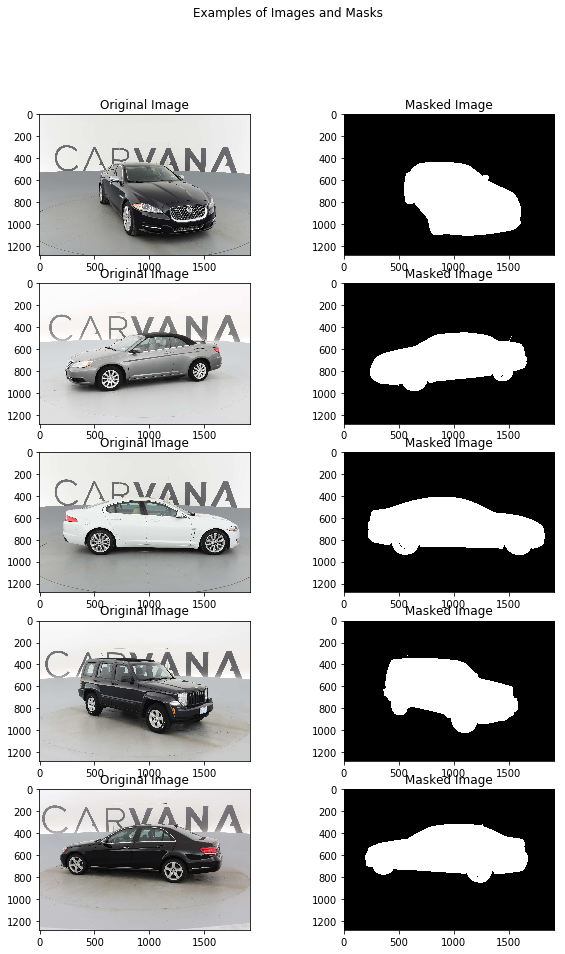

In [55]:
display_num = 5

r_choice = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num*2, 2):
    idx = i // 2
    x_path = x_train_filenames[idx]
    y_path = y_train_filenames[idx]
    
    plt.subplot(display_num, 2, i+1)
    plt.imshow(plt.imread(x_path))
    plt.title("Original Image")
    
    plt.subplot(display_num, 2, i+2)
    plt.imshow(plt.imread(y_path))
    plt.title("Masked Image")
    
#     example_labels = Image.open(y_path)
#     label_vals = np.unique(example_labels)  
#     plt.subplot(display_num, 2, i + 2)
#     plt.imshow(example_labels)
#     plt.title("Masked Image") 

plt.suptitle("Examples of Images and Masks")
plt.show()


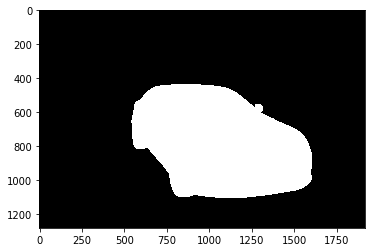

In [39]:
plt.imshow(plt.imread(y_train_filenames[0]))

In [41]:
example_labels = Image.open(y_train_filenames[0])

In [45]:
a = np.unique(example_labels)
print(a)

[0 1]
